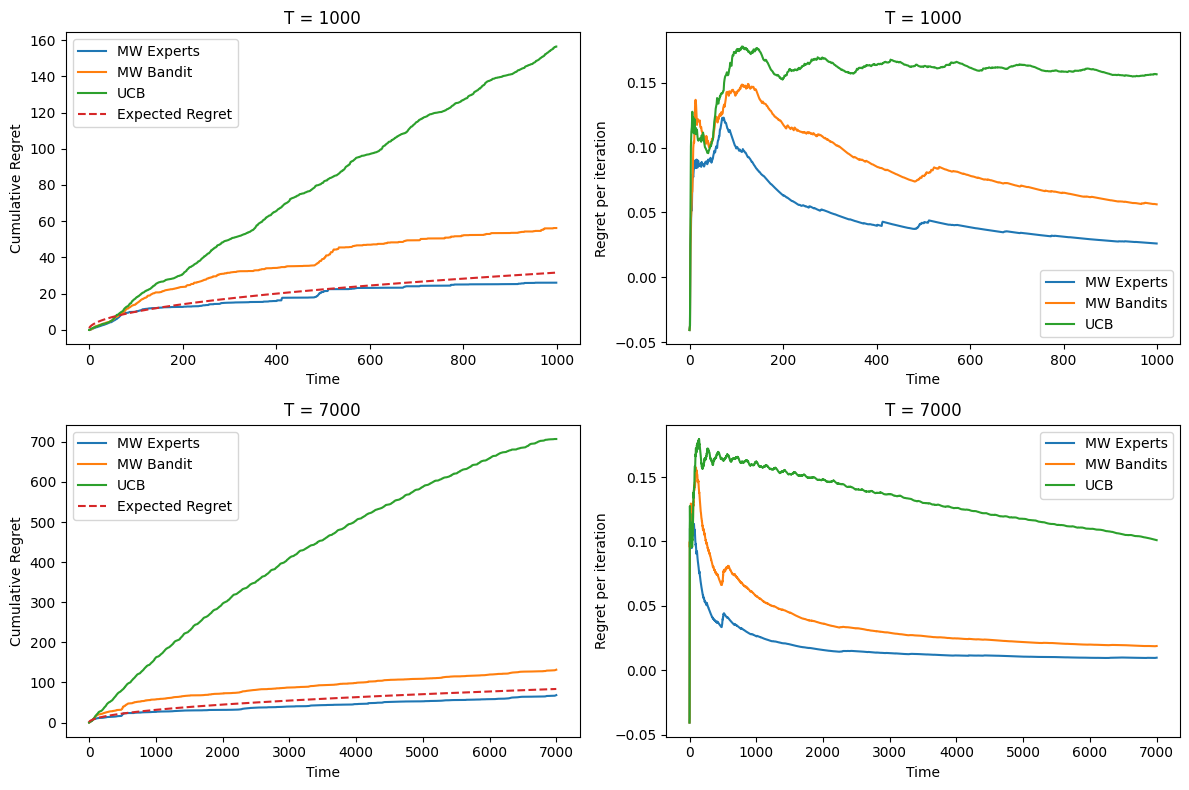

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# Load the dataset
data = pd.read_csv("Milano_timeseries.csv", header = None)
n_servers = data.shape[0]

# Define the horizon T
T_1 = 1000
T_3 = 7000
exploration_prob = 0.2
eta = 0.2

# This function uses the Multiplicative Weights Experts algorithm to select a server
# from a set of servers based on their past performance.
# Inputs:
#   - data: a pandas DataFrame containing the losses of each server at each time step
#   - T: the number of time steps to run the algorithm for
#   - eta: the learning rate of the algorithm (default value of 0.1)
# Outputs:
#   - regret: a numpy array containing the cumulative regret at each time step
#   - mean_regret: a numpy array containing the mean regret at each time step

def mw_experts(data, T, eta):
    # Initialize the weights of each server to be equal
    weights = np.ones(n_servers)

    # Initialize the loss and regrets to zero
    loss = np.zeros((T,))
    regret = np.zeros((T,))
    mean_regret = np.zeros((T,))

    # Run the algorithm for T time steps
    for t in range(T):
        # Compute the probability distribution over servers based on their weights
        W = np.sum(weights)
        probs = weights / W

        # Choose a server with probability proportional to its weight
        server_chosen = np.random.choice(n_servers, p=probs)

        # Update the weights based on the observed losses of all servers
        losses = data.iloc[:, t]
        weights = np.multiply(np.power(1 - eta, losses), weights)
        loss[t] = losses[server_chosen]

        # Compute the current regret and update the cumulative regret and mean regret
        current_regret = loss[t] if t > 1 else 0
        optimal_regret = np.min(losses)
        regret[t] = regret[t-1] + current_regret - optimal_regret
        mean_regret[t] = regret[t]/(t+1)

    return regret, mean_regret

# This function uses the Multiplicative Weights Bandits algorithm to select a server
# from a set of servers based on their past performance.
# Inputs:
#   - data: a pandas DataFrame containing the losses of each server at each time step
#   - T: the number of time steps to run the algorithm for
#   -exploration_prob: probability of exploration in the multi-armed bandit problem
#   - eta: the learning rate of the algorithm (default value of 0.1)
# Outputs:
#   - regret: a numpy array containing the cumulative regret at each time step
#   - mean_regret: a numpy array containing the mean regret at each time step
def mw_bandit(data, T, exploration_prob, eta):
    # Initialize the weights of each server to be equal
    weights = np.ones(n_servers)

    # Initialize the loss and regrets to zero
    loss = np.zeros((T,))
    regret = np.zeros((T,))
    mean_regret = np.zeros((T,))

    # Initialize exploration probability
    exploration = exploration_prob / n_servers * np.ones(n_servers)

    # Run the algorithm for T time steps
    for t in range(T):
        # Compute the probability distribution over servers based on their weights and exploration probability
        W = np.sum(weights)
        probs = (1 - exploration) * weights / W + exploration / n_servers

        # Choose a server with probability proportional to its weight
        server_chosen = np.random.choice(n_servers, p=probs)

        # Update the weights based on the observed losses of all servers
        losses = data.iloc[:, t]
        losses_hat = np.zeros(n_servers)
        losses_hat[server_chosen] = losses[server_chosen] / probs[server_chosen]
        weights = np.multiply(np.power(1 - eta, losses_hat), weights)
        loss[t] = losses[server_chosen]

        # Compute the current regret and update the cumulative regret and mean regret
        current_regret = loss[t] if t > 1 else 0
        optimal_regret = np.min(losses)
        regret[t] = regret[t - 1] + current_regret - optimal_regret
        mean_regret[t] = regret[t] / (t + 1)

    return regret, mean_regret
# This function uses the UCB algorithm to select a server
# Inputs:
#   -data: a pandas dataframe where each row represents a server and each column represents a time step
#   -T: the number of time steps to run the algorithm for
# Outputs:
#   - regret: a numpy array containing the cumulative regret at each time step
#   - mean_regret: a numpy array containing the mean regret at each time step
def ucb(data, T):
    # initialize variables
    n_servers = data.shape[0]  # number of servers
    loss_hat = np.zeros(n_servers)  # estimated loss for each server
    Q = np.ones(n_servers)  # number of times each server has been selected
    N = np.zeros(n_servers)  # number of times each server has been played
    loss = np.zeros(T)  # actual loss at each time step
    regret = np.zeros(T)  # instantaneous regret at each time step
    mean_regret = np.zeros(T)  # mean regret at each time step

    for t in range(T):
        # compute upper confidence bounds for each server
        ucb_values = loss_hat - np.sqrt(np.log(T) / Q)

        # choose server with smallest UCB value
        server_chosen = np.argmin(ucb_values)

        # play chosen server and update estimates
        losses = data.iloc[:, t]  # losses for all servers at current time step
        N[server_chosen] += 1  # increment number of times chosen server has been played
        Q[server_chosen] += 1  # increment number of times chosen server has been selected
        loss_hat[server_chosen] += (losses[server_chosen] - loss_hat[server_chosen]) / N[server_chosen]  # update estimated loss

        # update loss and regret
        loss[t] = losses[server_chosen]  # actual loss at current time step
        current_regret = loss[t] if t > 1 else 0  # instantaneous regret at current time step
        optimal_regret = np.min(losses)  # instantaneous regret if optimal server were chosen
        regret[t] = regret[t - 1] + current_regret - optimal_regret  # update total regret
        mean_regret[t] = regret[t] / (t + 1)  # update mean regret

    # return total regret and mean regret at each time step
    return regret, mean_regret




def plot_regrets_and_rewards(T_values):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    # loop over all combinations of T and k values
    for i, T in enumerate(T_values):
        
        mw_experts_regret_t, mw_experts_cumulative_regret_t = mw_experts(data, T, eta)
        mw_bandit_regret_t, mw_bandit_cumulative_regret_t= mw_bandit(data, T, exploration_prob, eta)
        ucb_regret_t, ucb_mean_regret_t = ucb(data, T)
        # plot the cumulative regret for each algorithm
        axs[i, 0].plot(mw_experts_regret_t, label="MW Experts")
        axs[i, 0].plot(mw_bandit_regret_t, label="MW Bandit")
        axs[i, 0].plot(ucb_regret_t, label="UCB")
        # plot the expected regret for each algorithm
        expected_regret = np.sqrt(np.arange(1, T + 1))
        axs[i, 0].plot(expected_regret, label="Expected Regret", linestyle='--')
        # set labels and title for the subplot
        axs[i, 0].set_xlabel("Time")
        axs[i, 0].set_ylabel("Cumulative Regret")
        axs[i, 0].set_title(f"T = {T}")
        # show a legend on the subplot
        axs[i, 0].legend()
        
        # plot the cumulative reward for each algorithm
        axs[i, 1].plot(mw_experts_cumulative_regret_t, label="MW Experts")
        axs[i, 1].plot(mw_bandit_cumulative_regret_t, label="MW Bandits")
        axs[i, 1].plot(ucb_mean_regret_t, label="UCB")
        # set labels and title for the subplot
        axs[i, 1].set_xlabel("Time")
        axs[i, 1].set_ylabel("Regret per iteration")
        axs[i, 1].set_title(f"T = {T}")
        # show a legend on the subplot
        axs[i, 1].legend()
        
    # adjusts the spacing between subplots
    plt.tight_layout()
    # displays the figure with all the subplots
    plt.show()


T_values = [1000, 7000]

plot_regrets_and_rewards(T_values)